# GENIE3: Experimenting with GENIE3

#### Modules Importation

In [1]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import *
from sklearn.metrics import *
from numpy import *
import time
from operator import itemgetter
from multiprocessing import Pool
import igraph
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def compute_feature_importances(estimator):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = asarray(importances)
        return sum(importances,axis=0) / len(estimator)

In [3]:
def get_link_list(VIM,gene_names=None,regulators='all',maxcount='all',file_name=None):
    
    """Gets the ranked list of (directed) regulatory links.
    
    Parameters
    ----------
    
    VIM: numpy array
        Array as returned by the function GENIE3(), in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. 
        
    gene_names: list of strings, optional
        List of length p, where p is the number of rows/columns in VIM, containing the names of the genes. The i-th item of gene_names must correspond to the i-th row/column of VIM. When the gene names are not provided, the i-th gene is named Gi.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names), and the returned list contains only edges directed from the candidate regulators. When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    maxcount: 'all' or positive integer, optional
        Writes only the first maxcount regulatory links of the ranked list. When maxcount is set to 'all', all the regulatory links are written.
        default: 'all'
        
    file_name: string, optional
        Writes the ranked list of regulatory links to the file file_name.
        default: None
        
        
    
    Returns
    -------
    
    The list of regulatory links, ordered according to the edge score. Auto-regulations do not appear in the list. Regulatory links with a score equal to zero are randomly permuted. In the ranked list of edges, each line has format:
        
        regulator   target gene     score of edge
    """
    
    # Check input arguments      
    if not isinstance(VIM,ndarray):
        raise ValueError('VIM must be a square array')
    elif VIM.shape[0] != VIM.shape[1]:
        raise ValueError('VIM must be a square array')
        
    ngenes = VIM.shape[0]
        
    if gene_names != None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expression data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('The genes must contain at least one candidate regulator')
        
    if maxcount != 'all' and not isinstance(maxcount,int):
        raise ValueError('input argument maxcount must be "all" or a positive integer')
        
    if file_name != None and not isinstance(file_name,str):
        raise ValueError('input argument file_name must be a string')
    
    

    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = range(ngenes)
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]
    
    # Get the non-ranked list of regulatory links
    vInter = [(i,j,score) for (i,j),score in ndenumerate(VIM) if i in input_idx and i!=j]
    
    # Rank the list according to the weights of the edges        
    vInter_sort = sorted(vInter,key=itemgetter(2),reverse=True)
    nInter = len(vInter_sort)
    
    # Random permutation of edges with score equal to 0
    flag = 1
    i = 0
    while flag and i < nInter:
        (TF_idx,target_idx,score) = vInter_sort[i]
        if score == 0:
            flag = 0
        else:
            i += 1
            
    if not flag:
        items_perm = vInter_sort[i:]
        items_perm = random.permutation(items_perm)
        vInter_sort[i:] = items_perm
        
    # Write the ranked list of edges
    nToWrite = nInter
    if isinstance(maxcount,int) and maxcount >= 0 and maxcount < nInter:
        nToWrite = maxcount
        
    if file_name:
    
        outfile = open(file_name,'w')
    
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('%s\t%s\t%.6f\n' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('G%d\tG%d\t%.6f\n' % (TF_idx+1,target_idx+1,score))
            
        
        outfile.close()
        
    else:
        
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('%s\t%s\t%.6f' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('G%d\tG%d\t%.6f' % (TF_idx+1,target_idx+1,score))

In [4]:
def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------

    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET' and tree_method != 'GB' and tree_method != 'AB':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
        
    if verbose==True:    
        print('Tree method: ' + str(tree_method))
        print('K: ' + str(K))
        print('Number of trees: ' + str(ntrees))
        print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        if verbose==True:
            print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        if verbose==True:
            print('running single threaded jobs')
        for i in range(ngenes):
            if verbose==True:
                if i%10==0:
                    print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    if verbose==True:
        print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM

In [5]:
def wr_GENIE3_single(args):
    return([args[1], GENIE3_single(args[0], args[1], args[2], args[3], args[4], args[5])])

In [15]:
def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features)  
    elif tree_method == 'GB':
        treeEstimator = GradientBoostingClassifier(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'AB':
        treeEstimator = AdaBoostClassifier(n_estimators=ntrees)
        

    # Learn ensemble of trees
    if tree_method == 'RF' or tree_method == 'ET':
        treeEstimator.fit(expr_data_input,output)
    elif tree_method == 'GB' or tree_method == 'AB':
    
    # Compute importance scores
    feature_importances = compute_feature_importances(treeEstimator)
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi

In [7]:
def GetFilePaths(rootPath):
    filesList=[]
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            indexFiles=file.endswith("indexes.tsv")
            steadyFiles=file.endswith("steadyState.tsv")
            timeFiles=file.endswith("timeSeries.tsv")
            tsvFiles=file.endswith(".tsv")
            if  tsvFiles and not indexFiles and not steadyFiles and not timeFiles:
                filesList.append(os.path.join(root, file))
    return filesList

def WriteValues(rootPath):
    
    files=GetFilePaths(rootPath)
    fluxWriteSteady=open(rootPath+'steadyState.tsv','w')
    flagHeaderSteady=0
    regexHeaderSteady=".*G.*"
    
    fluxWriteTime=open(rootPath+'timeSeries.tsv','w')   
    
    for file in files:
        
        fluxRead=open(file,'r')
        lines=fluxRead.readlines()
        
        
        
        if file.endswith("timeseries.tsv"):
            for line in lines:
                fluxWriteTime.write(line)        
            
        else :
            
            if lines and flagHeaderSteady==0:
                if(re.match(regexHeaderSteady,lines[0])):
                    flagHeaderSteady=1
                    fluxWriteSteady.write(re.match(regexHeaderSteady,lines[0]).group(0)+'\n')
                    
            if flagHeaderSteady==1:
                lines=lines[1:]
            for line in lines:
                fluxWriteSteady.write(line)
                
        fluxRead.close()
        
    fluxWriteSteady.close()
    fluxWriteTime.close()
        
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_1/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_2/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_3/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_4/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_5/')

In [8]:
def ReadGoldStandard(path):
    flux=open(path,'r')
    lignes=flux.readlines()
    connexionList=[]
    for ligne in lignes:
        listeTemp=ligne.split('\n')[0].split('\t')
        connexionList.append([int(listeTemp[0][1:]),int(listeTemp[1][1:]),int(listeTemp[2])])
    connexionList=array(connexionList)
    nbOfVariables=max(connexionList[:,0])
    correctionMatrix=zeros((nbOfVariables,nbOfVariables))
    for connexion in connexionList:
        correctionMatrix[connexion[0]-1,connexion[1]-1]=connexion[2]
    return correctionMatrix

In [9]:
def Score(matrixTest,matrixCorr,precision):
    
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),VIM.flatten())
    
    listTreshold=treshold
    
    Precision =            lambda nbTP,nbFP : nbTP / (nbFP + nbTP)
    Recall = Sensitivity = lambda nbTP,nbFN : nbTP / (nbTP + nbFN)
    Specificity =          lambda nbTN,nbFP : nbTN / (nbTN + nbFP)
    
    listROC=[]
    listPR=[]
  
    for treshold in listTreshold:
        matrixTreshold=zeros(matrixTest.shape)
        matrixTreshold[where(matrixTest>treshold)]=1
        nbFP=0
        nbFN=0
        nbTP=0
        nbTN=0
        for i in range(matrixTreshold.shape[0]):
            for j in range(matrixTreshold.shape[1]):
                if j!=i:
                    
                    if matrixTreshold[i,j]==0:
                        if matrixCorr[i,j]==0:
                            nbTN+=1
                        else:
                            nbFN+=1
                    else:
                        if matrixCorr[i,j]==1:
                            nbTP+=1
                        else:
                            nbFP+=1
                            
        if(nbTP+nbFP)!=0 and (nbTP+nbFN)!=0:
            listPR.append([Recall(nbTP,nbFN),Precision(nbTP,nbFP),treshold])
        if(nbTP+nbFN)!=0 and (nbTN+nbFP)!=0:
            listROC.append([1-Specificity(nbTN,nbFP),Sensitivity(nbTP,nbFN),treshold])
    listPR.append([0,1,-1])    
    return array(listPR),array(listROC)    

In [10]:
#Getting Gene names
f = open('../../dream_data/training_data/InSilico_10/insilico_size10_1/steadyState.tsv')
gene_names = f.readline()
gene_names = gene_names.rstrip('\n').split('\t')
f.close()

In [11]:
def ScoresFromSteadyFile(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    """
    Calculate the AUPR and AUROC scores directly from:
    -The SteadyState files (training data) 
    -The Goldstandard files(correction)
    
    Returns the AUPR and AUROC score
    """
    
    #Loading the files
    data=loadtxt(steadyFilePath,skiprows=1)
    corrMatrix=ReadGoldStandard(trueNetworkFilePath)
    
    #Creating the inferred connetion matrix
    inferedMatrix=GENIE3(data,gene_names=None,regulators='all',tree_method=tree_method,K='sqrt',ntrees=1000,nthreads=1)

    #Calculating the PR curve
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),inferedMatrix.flatten())

    #Calculating the ROC curve
    fpr,tpr,tresholds=roc_curve(corrMatrix.flatten(),inferedMatrix.flatten())
    
    #Calculating the Area under the curve for PR
    AUPR=auc(recall,precision)
    #Calculating the areau under the curve for ROC
    AUROC=auc(fpr,tpr)
    
    return AUPR,AUROC,[recall,precision],[fpr,tpr]

In [16]:
#Correction file paths
gold_1='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_1.tsv'
gold_2='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_2.tsv'
gold_3='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_3.tsv'
gold_4='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_4.tsv'
gold_5='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_5.tsv'

#Training data paths
data_1='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_2='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_3='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_4='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_5='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'

#Search methods
searchMethods=["ET","RF","AB","GB"]

#Data Paths
dataPaths=[data_1,data_2,data_3,data_4,data_5]
#Correction Paths
corrPaths=[gold_1,gold_2,gold_3,gold_4,gold_5]

#Scores by methods (first Axis) and paths (second Axis)
scoreAUPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

a,b=ScoresFromSteadyFile(dataPaths[0],corrPaths[0],tree_method=searchMethods[1],verbose=False)

a,b=ScoresFromSteadyFile(dataPaths[0],corrPaths[0],tree_method=searchMethods[2],verbose=False)

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        scoreAUPR[i][j],
        scoreAUROC[i][j]=ScoresFromSteadyFile(dataPaths[j],
                                              corrPaths[j],
                                              tree_method=searchMethods[i],
                                              verbose=False)

Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/100...
[[0.3773118 0.4933734 0.1828963 ... 0.4778708 0.0328088 0.5699604]
 [0.3338101 0.3857391 0.0582125 ... 0.4468232 0.0065561 0.4677665]
 [0.313279  0.4351399 0.1537951 ... 0.393398  0.0302167 0.5934666]
 ...
 [0.3096201 0.4898805 0.086354  ... 0.5632502 0.0055914 0.526624 ]
 [0.3880082 0.4470457 0.1650933 ... 0.4530106 0.4743811 0.4024433]
 [0.1909148 0.3023966 0.1014808 ... 0.3945163 0.0040215 0.7057016]]
[1.84648705 1.94285092 1.23879289 0.40975777 0.40133275 1.1300938
 0.36459115 1.07645825 3.1121678  3.00972092 0.9727986  0.55267733
 3.37295487 1.58706286 3.51057303 3.00661428 0.93994171 1.6002505
 1.36706424 3.42086281 0.68226128 0.63688156 0.44257501 3.06736579
 0.66752811 3.83325641 3.32827179 3.61293708 0.80729218 0.63536859
 0.75405877 1.44593167 2.19238031 2.04116174 2.49364855 2.89658701
 2.27169023 2.44813076 1.99277874 1.27466792 3.13999162 2.01637164
 3.33175933 2.07428058 2.47791358 

[[0.2608087 0.3773118 0.4933734 ... 0.4778708 0.0328088 0.5699604]
 [0.2744197 0.3338101 0.3857391 ... 0.4468232 0.0065561 0.4677665]
 [0.1749744 0.313279  0.4351399 ... 0.393398  0.0302167 0.5934666]
 ...
 [0.0488341 0.3096201 0.4898805 ... 0.5632502 0.0055914 0.526624 ]
 [0.0642824 0.3880082 0.4470457 ... 0.4530106 0.4743811 0.4024433]
 [0.1245994 0.1909148 0.3023966 ... 0.3945163 0.0040215 0.7057016]]
[4.43971237 2.97993833 3.82410318 4.62190704 4.48401674 4.57576184
 4.76539296 3.62104968 4.41022802 4.36859292 4.5031383  4.30216098
 4.47967248 5.01173918 2.94924679 4.29398879 2.74148405 0.75410634
 3.27220959 4.0367801  3.40431961 4.89789403 4.71826362 4.09977443
 3.77570076 2.42628791 2.44977111 5.38077331 3.11335619 4.72148398
 3.95373584 4.32557249 5.07561988 3.70851425 4.22246163 5.07395213
 5.53382399 3.32522784 3.24124578 4.69914351 5.08784812 4.35728292
 4.65624402 4.27578257 3.46196889 4.28878566 3.37156783 5.18049481
 2.94872902 4.6001908  2.32354927 3.33903113 4.35151205 

[[0.2608087 0.3773118 0.4933734 ... 0.4778708 0.0328088 0.5699604]
 [0.2744197 0.3338101 0.3857391 ... 0.4468232 0.0065561 0.4677665]
 [0.1749744 0.313279  0.4351399 ... 0.393398  0.0302167 0.5934666]
 ...
 [0.0488341 0.3096201 0.4898805 ... 0.5632502 0.0055914 0.526624 ]
 [0.0642824 0.3880082 0.4470457 ... 0.4530106 0.4743811 0.4024433]
 [0.1245994 0.1909148 0.3023966 ... 0.3945163 0.0040215 0.7057016]]
[1.65079855 1.36840848 0.91233017 3.97627076 3.47039586 1.38925679
 1.22560964 2.76034783 1.24969097 0.99480478 2.27642651 3.70194943
 0.53594224 1.06824407 3.6657     2.18746553 1.6556488  1.8736632
 2.07220035 1.75559564 0.92588967 3.62482833 1.39623697 2.05674984
 1.10973881 3.56035681 1.09212788 1.00931922 3.20414183 3.41498724
 2.59975215 2.2237767  1.08660009 2.11108297 3.27690794 1.54365222
 0.78342561 1.95023893 0.80969714 2.57433462 2.3761475  1.73614453
 0.5807448  2.98773812 0.90417937 1.15507004 4.02077412 1.62710573
 1.5294268  2.29999587 4.24931907 2.682982   1.81180089 0

KeyboardInterrupt: 

### Presenting the results

#### Area under curves

In [25]:
#Presenting the results
col_names=["NET1","NET2","NET3","NET4","NET5"]
row_names=["AUPR","AUROC"]
values=[[AUPR_1,AUPR_2,AUPR_3,AUPR_4,AUPR_5],[AUROC_1,AUROC_2,AUROC_3,AUROC_4,AUROC_5]]

tab=pd.DataFrame(values,columns=col_names,index=row_names)
display(tab)


,NET1,NET2,NET3,NET4,NET5
AUPR,0.160184,0.160682,0.154639,0.153083,0.158916
AUROC,0.751921,0.753226,0.746221,0.749121,0.752048


#### PR and ROC curves

Text(0.5, 1.0, 'ROC Curve Net 5')

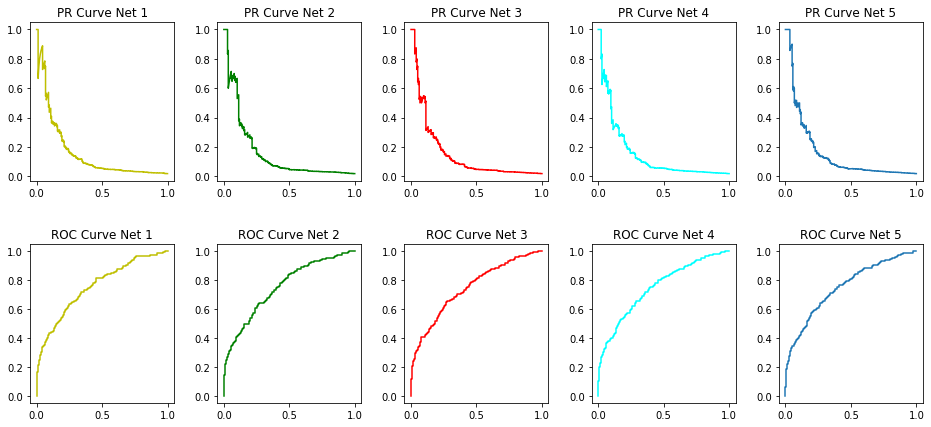

In [18]:
#Creating Figure
fig,axs=plt.subplots(2,5,figsize=(16,7))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

#Creating the plots 

#NET1
axs[0,0].plot(PR1[0],PR1[1],c='y')
axs[0,0].set_title('PR Curve Net 1')
axs[1,0].plot(ROC1[0],ROC1[1],c='y')
axs[1,0].set_title('ROC Curve Net 1')

#NET2
axs[0,1].plot(PR2[0],PR2[1],c='g')
axs[0,1].set_title('PR Curve Net 2')
axs[1,1].plot(ROC2[0],ROC2[1],c='g')
axs[1,1].set_title('ROC Curve Net 2')

#NET3
axs[0,2].plot(PR3[0],PR3[1],c='r')
axs[0,2].set_title('PR Curve Net 3')
axs[1,2].plot(ROC3[0],ROC3[1],c='r')
axs[1,2].set_title('ROC Curve Net 3')

#NET4
axs[0,3].plot(PR4[0],PR4[1],c='cyan')
axs[0,3].set_title('PR Curve Net 4')
axs[1,3].plot(ROC4[0],ROC4[1],c='cyan')
axs[1,3].set_title('ROC Curve Net 4')

#NET5
axs[0,4].plot(PR5[0],PR5[1])
axs[0,4].set_title('PR Curve Net 5')
axs[1,4].plot(ROC5[0],ROC5[1])
axs[1,4].set_title('ROC Curve Net 5')




In [19]:
#Plotting a Graph
data=loadtxt(data_1,skiprows=1)
VIM=GENIE3(data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1)
conn_indices = where(VIM) 
weights = VIM[conn_indices]
edges = zip(*conn_indices)
g=igraph.Graph(directed=True,edges=edges)
g.es['weight']=VIM
g.es["width"]=weights * 4
g.vs['label']=gene_names

Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/100...
Gene 11/100...
Gene 21/100...
Gene 31/100...
Gene 41/100...
Gene 51/100...
Gene 61/100...
Gene 71/100...
Gene 81/100...
Gene 91/100...
Elapsed time: 147.59 seconds


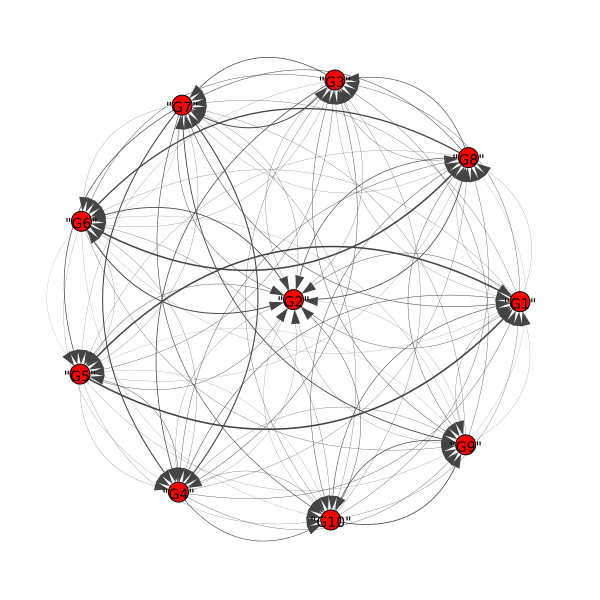

In [17]:
igraph.plot(g,labels=True,margin=80)